In [16]:
import cv2
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import pandas as pd

In [9]:

def extract_price_data(image_path):
    """
    Extracts a price series from the image by averaging pixel values along rows.
    The result is normalized to a specified price range.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    height, width = img.shape
    # Average each row and invert the array to simulate a bottom-origin axis.
    prices = np.mean(img, axis=1)[::-1]
    # Clip the background (assumed white=255) to remove its influence.
    prices = np.clip(prices, 0, 254)
    
    # Normalize to your chart’s price range (e.g., $47.5–$65.0)
    min_price, max_price = 47.5, 65.0
    # Invert the scaling to match the chart (higher grayscale values = lower prices)
    normalized_prices = max_price - (max_price - min_price) * (prices - np.min(prices)) / (np.max(prices) - np.min(prices))
    return normalized_prices


In [10]:
def moving_average(data, window_size=5):
    """
    Applies a simple moving average filter to smooth the data.
    """
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')


In [11]:
def detect_pattern(prices, similarity_threshold=5.0, breakout_threshold=15.0, distance=20):
    """
    Detects double top or double bottom patterns in a price series.
    Returns the detected pattern, decision, auxiliary pattern data, and the indices of peaks and troughs.
    """
    # Detect troughs (for double bottom) and peaks (for double top)
    troughs, _ = find_peaks(-prices, distance=distance, height=48.0)
    peaks, _ = find_peaks(prices, distance=distance, height=60.0)

    pattern = "No Pattern"
    decision = "Hold"
    pattern_data = {}

    # Check for double bottom (buy signal)
    if len(troughs) >= 2:
        t1, t2 = troughs[-2], troughs[-1]
        if abs(prices[t1] - prices[t2]) < similarity_threshold:
            peak_between = max(prices[t1:t2])
            if t2 < len(prices) - 1 and prices[t2 + 1] > peak_between + breakout_threshold:
                pattern = "Double Bottom"
                decision = "Buy"
                pattern_data = {"troughs": [t1, t2]}

    # Check for double top (sell signal)
    if len(peaks) >= 2:
        p1, p2 = peaks[-2], peaks[-1]
        if abs(prices[p1] - prices[p2]) < similarity_threshold:
            trough_between = min(prices[p1:p2])
            if p2 < len(prices) - 1 and prices[p2 + 1] < trough_between - breakout_threshold:
                pattern = "Double Top"
                decision = "Sell"
                pattern_data = {"peaks": [p1, p2]}

    return pattern, decision, pattern_data, peaks, troughs


In [12]:
def markup_image(image_path, prices, pattern, pattern_data, peaks, troughs):
    """
    Draws markers (circles) on the original image where peaks or troughs were detected.
    """
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    
    if pattern == "Double Bottom" and "troughs" in pattern_data:
        for t in pattern_data["troughs"]:
            x = int(t * width / len(prices))
            # Map price to y-coordinate (with a small vertical buffer)
            y = int((prices[t] - np.min(prices)) / (np.max(prices) - np.min(prices)) * (height - 30) + 15)
            cv2.circle(img, (x, y), 10, (0, 255, 0), 2)  # Green circle
    elif pattern == "Double Top" and "peaks" in pattern_data:
        for p in pattern_data["peaks"]:
            x = int(p * width / len(prices))
            y = int((prices[p] - np.min(prices)) / (np.max(prices) - np.min(prices)) * (height - 30) + 15)
            cv2.circle(img, (x, y), 10, (0, 0, 255), 2)  # Red circle
    return img


In [13]:
def run_experiment(image_path, smoothing_window=5):
    """
    Runs the experiment using both raw and smoothed price data.
    Prints debug information, marks the image with detected patterns,
    and plots the price series for visual inspection.
    """
    # Extract raw price data from the image
    raw_prices = extract_price_data(image_path)
    # Apply a moving average smoothing filter
    smoothed_prices = moving_average(raw_prices, window_size=smoothing_window)
    similarity_threshold=5.0
    breakout_threshold=15.0
    distance=20
    # Detect patterns on both raw and smoothed data
    pattern_raw, decision_raw, pattern_data_raw, peaks_raw, troughs_raw = detect_pattern(raw_prices,similarity_threshold, breakout_threshold, distance)
    pattern_smoothed, decision_smoothed, pattern_data_smoothed, peaks_smoothed, troughs_smoothed = detect_pattern(smoothed_prices,similarity_threshold, breakout_threshold, distance)

    print("Raw Data Detection:")
    print("  Pattern:", pattern_raw, "| Decision:", decision_raw)
    print("  Peaks indices:", peaks_raw)
    print("  Troughs indices:", troughs_raw)
    print("\nSmoothed Data Detection (window={}):".format(smoothing_window))
    print("  Pattern:", pattern_smoothed, "| Decision:", decision_smoothed)
    print("  Peaks indices:", peaks_smoothed)
    print("  Troughs indices:", troughs_smoothed)

    # Choose which detection result to mark on the image.
    # Here we use the smoothed data result.
    marked_img = markup_image(image_path, smoothed_prices, pattern_smoothed, pattern_data_smoothed, peaks_smoothed, troughs_smoothed)
    output_path = "experiment_output.png"
    cv2.imwrite(output_path, marked_img)
    print("\nMarked image saved as", output_path)

    # Plot raw and smoothed price series for comparison
    plt.figure(figsize=(10, 5))
    plt.plot(raw_prices, label='Raw Prices')
    plt.plot(smoothed_prices, label='Smoothed Prices', linestyle='--')
    plt.title("Price Data: Raw vs. Smoothed")
    plt.xlabel("Time Index")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
    plt.close()

Raw Data Detection:
  Pattern: No Pattern | Decision: Hold
  Peaks indices: [ 65 527]
  Troughs indices: []

Smoothed Data Detection (window=10):
  Pattern: No Pattern | Decision: Hold
  Peaks indices: []
  Troughs indices: []

Marked image saved as experiment_output.png


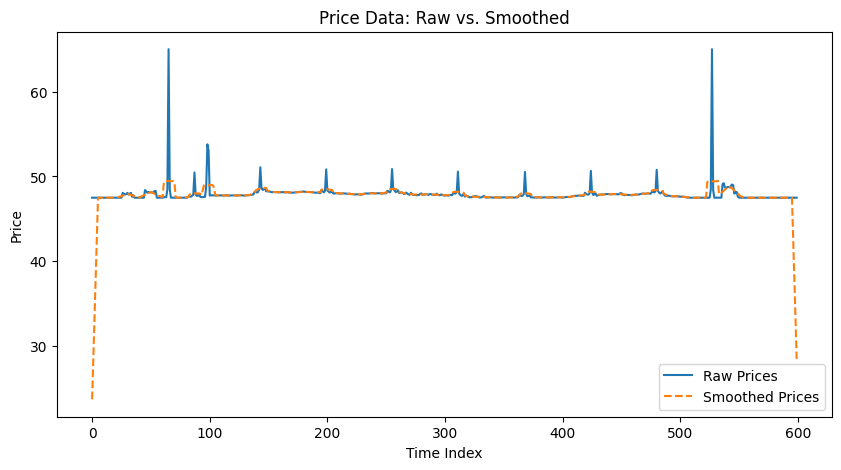

In [39]:

if __name__ == '__main__':
    # Update with the path to your chart image
    image_path = r"static\output.png"
    run_experiment(image_path, smoothing_window=10)


In [36]:
normalised_prices1=pd.DataFrame(extract_price_data(image_path))

In [37]:
html_table = normalised_prices1.to_markdown()
print(normalised_prices1.iloc[65])
print(normalised_prices1.iloc[527])

0    65.0
Name: 65, dtype: float64
0    65.0
Name: 527, dtype: float64


In [40]:
normalised_prices2 = pd.DataFrame(extract_price_data(image_path))
html_table = normalised_prices2.to_markdown()
print(normalised_prices2.iloc[65])
print(normalised_prices2.iloc[527])

0    65.0
Name: 65, dtype: float64
0    65.0
Name: 527, dtype: float64
